In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_train = pd.read_csv('Google_Stock_Price_Train.csv', parse_dates=True, index_col='Date')

In [3]:
df_test = pd.read_csv('Google_Stock_Price_Test.csv', parse_dates=True, index_col='Date')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   object 
 4   Volume  1258 non-null   object 
dtypes: float64(3), object(2)
memory usage: 59.0+ KB


In [5]:
df_train.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


In [6]:
df_train['Close'] = df_train['Close'].apply(lambda x: float(''.join(x.split(','))))

In [7]:
df_train['Volume'] = df_train['Volume'].apply(lambda x: float(''.join(x.split(','))))

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   float64
 4   Volume  1258 non-null   float64
dtypes: float64(5)
memory usage: 59.0 KB


<AxesSubplot:xlabel='Date'>

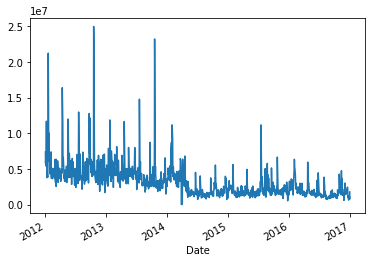

In [9]:
df_train['Volume'].plot()

<AxesSubplot:xlabel='Date'>

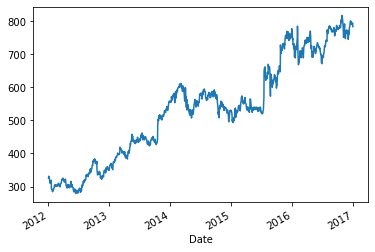

In [10]:
df_train['Open'].plot()

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2017-01-03 to 2017-01-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    20 non-null     float64
 1   High    20 non-null     float64
 2   Low     20 non-null     float64
 3   Close   20 non-null     float64
 4   Volume  20 non-null     object 
dtypes: float64(4), object(1)
memory usage: 960.0+ bytes


In [12]:
df_test['Volume'] = df_test['Volume'].apply(lambda x: float(''.join(x.split(','))))

In [13]:
test_size = len(df_test)

In [14]:
test_size

20

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()

In [17]:
scaler.fit(df_train)

MinMaxScaler()

In [18]:
scaled_train = scaler.transform(df_train)
scaled_test = scaler.transform(df_test)

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
length = 10

In [22]:
generator = TimeseriesGenerator(scaled_train, scaled_train, length = length , batch_size=1)
val_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [23]:
scaled_train.shape

(1258, 5)

In [24]:
n_features = scaled_train.shape[1]

In [25]:
from tensorflow.keras.models import Sequential

In [26]:
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [27]:
model = Sequential()

model.add(LSTM(50, activation='relu',return_sequences=True, input_shape=(length, n_features)))
model.add(Dropout(0.1))
model.add(LSTM(50, activation='relu',return_sequences=True, input_shape=(length, n_features)))
model.add(Dropout(0.1))
model.add(LSTM(50, activation='relu', input_shape=(length, n_features)))
model.add(Dense(n_features))

model.compile(optimizer='adam', loss = 'mse')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 50)            11200     
_________________________________________________________________
dropout (Dropout)            (None, 10, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 5)                 255       
Total params: 51,855
Trainable params: 51,855
Non-trainable params: 0
____________________________________________________

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
early = EarlyStopping(monitor='val_loss', patience=1)

In [35]:
model.fit(generator, 
          epochs=8, 
          validation_data=val_generator, 
          callbacks = [early]
         )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1248 steps, validate for 10 steps
Epoch 1/8
1248/1248 [==============================] - 63s 51ms/step - loss: 0.0030 - val_loss: 0.0069
Epoch 2/8
1248/1248 [==============================] - 64s 52ms/step - loss: 0.0028 - val_loss: 0.0042
Epoch 3/8
1248/1248 [==============================] - 66s 53ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 4/8
1248/1248 [==============================] - 65s 52ms/step - loss: 0.0025 - val_loss: 0.0057


In [36]:
loss = pd.DataFrame(model.history.history)

<AxesSubplot:>

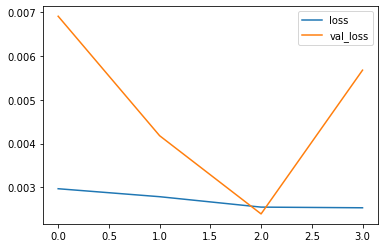

In [37]:
loss.plot()

In [38]:
test_predictions = []
n_features = scaled_train.shape[1]
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(df_test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [39]:
true_prediction = scaler.inverse_transform(test_predictions)

In [40]:
true_prediction

array([[7.50489295e+02, 7.61828943e+02, 7.43179063e+02, 7.57935139e+02,
        2.08462877e+06],
       [7.44776052e+02, 7.56137274e+02, 7.36920379e+02, 7.50080491e+02,
        2.10365779e+06],
       [7.37940986e+02, 7.49358465e+02, 7.29524182e+02, 7.40404071e+02,
        2.12671199e+06],
       [7.30961799e+02, 7.42409604e+02, 7.22091862e+02, 7.30967348e+02,
        2.14606974e+06],
       [7.24361723e+02, 7.35803400e+02, 7.15183395e+02, 7.22532208e+02,
        2.16004682e+06],
       [7.18263570e+02, 7.29671857e+02, 7.08904573e+02, 7.15352231e+02,
        2.16894925e+06],
       [7.12842028e+02, 7.24208519e+02, 7.03440166e+02, 7.09783221e+02,
        2.17324568e+06],
       [7.08433849e+02, 7.19754635e+02, 6.99012108e+02, 7.05490373e+02,
        2.17454201e+06],
       [7.04244864e+02, 7.15538146e+02, 6.94832321e+02, 7.01686801e+02,
        2.17461941e+06],
       [7.00377730e+02, 7.11659015e+02, 6.90991742e+02, 6.98353453e+02,
        2.17420435e+06],
       [6.96834693e+02, 7.0811

In [41]:
df_train.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2016-12-23,790.90,792.74,787.28,789.91,623400.0
2016-12-27,790.68,797.86,787.66,791.55,789100.0
2016-12-28,793.70,794.23,783.20,785.05,1153800.0
2016-12-29,783.33,785.93,778.92,782.79,744300.0
2016-12-30,782.75,782.78,770.41,771.82,1770000.0


In [42]:
ind = df_test.index

In [43]:
true_prediction = pd.DataFrame(true_prediction,index=ind, columns=['P_Open', 'P_High', 'P_Low', 'P_Close', 'P_Volume'])

In [44]:
true_prediction

,P_Open,P_High,P_Low,P_Close,P_Volume
Date,,,,,
2017-01-03,750.489295,761.828943,743.179063,757.935139,2.084629e+06
2017-01-04,744.776052,756.137274,736.920379,750.080491,2.103658e+06
2017-01-05,737.940986,749.358465,729.524182,740.404071,2.126712e+06
2017-01-06,730.961799,742.409604,722.091862,730.967348,2.146070e+06
2017-01-09,724.361723,735.803400,715.183395,722.532208,2.160047e+06
2017-01-10,718.263570,729.671857,708.904573,715.352231,2.168949e+06
2017-01-11,712.842028,724.208519,703.440166,709.783221,2.173246e+06
2017-01-12,708.433849,719.754635,699.012108,705.490373,2.174542e+06
2017-01-13,704.244864,715.538146,694.832321,701.686801,2.174619e+06


In [45]:
df_test

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,778.81,789.63,775.80,786.14,1657300.0
2017-01-04,788.36,791.34,783.16,786.90,1073000.0
2017-01-05,786.08,794.48,785.02,794.02,1335200.0
2017-01-06,795.26,807.90,792.20,806.15,1640200.0
2017-01-09,806.40,809.97,802.83,806.65,1272400.0
2017-01-10,807.86,809.13,803.51,804.79,1176800.0
2017-01-11,805.00,808.15,801.37,807.91,1065900.0
2017-01-12,807.14,807.39,799.17,806.36,1353100.0
2017-01-13,807.48,811.22,806.69,807.88,1099200.0


In [46]:
final_df = pd.concat([df_test, true_prediction], axis=1)

In [47]:
final_df

,Open,High,Low,Close,Volume,P_Open,P_High,P_Low,P_Close,P_Volume
Date,,,,,,,,,,
2017-01-03,778.81,789.63,775.80,786.14,1657300.0,750.489295,761.828943,743.179063,757.935139,2.084629e+06
2017-01-04,788.36,791.34,783.16,786.90,1073000.0,744.776052,756.137274,736.920379,750.080491,2.103658e+06
2017-01-05,786.08,794.48,785.02,794.02,1335200.0,737.940986,749.358465,729.524182,740.404071,2.126712e+06
2017-01-06,795.26,807.90,792.20,806.15,1640200.0,730.961799,742.409604,722.091862,730.967348,2.146070e+06
2017-01-09,806.40,809.97,802.83,806.65,1272400.0,724.361723,735.803400,715.183395,722.532208,2.160047e+06
2017-01-10,807.86,809.13,803.51,804.79,1176800.0,718.263570,729.671857,708.904573,715.352231,2.168949e+06
2017-01-11,805.00,808.15,801.37,807.91,1065900.0,712.842028,724.208519,703.440166,709.783221,2.173246e+06
2017-01-12,807.14,807.39,799.17,806.36,1353100.0,708.433849,719.754635,699.012108,705.490373,2.174542e+06
2017-01-13,807.48,811.22,806.69,807.88,1099200.0,704.244864,715.538146,694.832321,701.686801,2.174619e+06


<AxesSubplot:xlabel='Date'>

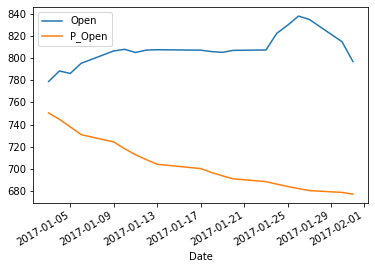

In [48]:
final_df[['Open','P_Open']].plot()

<AxesSubplot:xlabel='Date'>

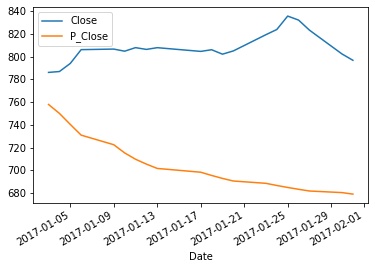

In [49]:
final_df[['Close','P_Close']].plot()

<AxesSubplot:xlabel='Date'>

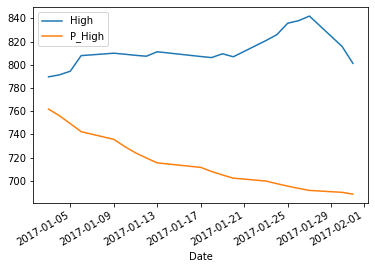

In [50]:
final_df[['High','P_High']].plot()

<AxesSubplot:xlabel='Date'>

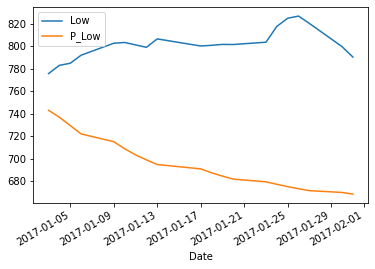

In [51]:
final_df[['Low','P_Low']].plot()

<AxesSubplot:xlabel='Date'>

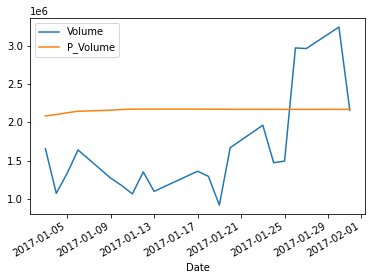

In [52]:
final_df[['Volume','P_Volume']].plot()